First we need to define the model:

$$ H = \sum_{n = 1}^{N - 1} [J_{n} ( \hat{\sigma}_{n}^{x}\hat{\sigma}_{n+1}^{x} + \hat{\sigma}_{n}^{y}\hat{\sigma}_{n+1}^{y}) + \Delta_{n} \hat{\sigma}_{n}^{z}\hat{\sigma}_{n+1}^{z}] $$

With $J_{n}$ and $\Delta_{n}$ given as:

- $J_{n} = J_{L}, \Delta_{n} = \Delta_{L}$ for $n < N/2$
- $J_{N/2} = J_{M}, \Delta_{N/2} = \Delta_{M}$
- $J_{n} = J_{R}, \Delta_{n} = \Delta_{R}$ for $n > N/2$

Note: We will consider N as even number.



In [1]:
using LinearAlgebra
using Base
using Plots
using LaTeXStrings

In [2]:
# Matrix Representations and kroenecker products:
Sigma_x = [0 1; 1 0]
Sigma_y = [0 -1im; 1im 0]
Sigma_z = [1 0; 0 -1]

Identity = [1 0; 0 1] #or Using LinearAlgebra and Matrix{Float64}(I, 2, 2)

function S_Term(N, cte_list, SigmaMatrix)
    # I⊗...⊗I⊗ΔSigma⊗Sigma⊗I...⊗I: Sigma can be Sigmax, Sigmay or Sigmaz.
    # cte_list = [cte_L, cte_M, cte_R], can be J or ∆.

    Matrix_Sigma = zeros(2^N, 2^N)

    cte_L = cte_list[1]
    cte_M = cte_list[2]
    cte_R = cte_list[3]    
    
    for i=1:N-1
        M = Identity
        
        if i == 1
            M = SigmaMatrix
        end
       
        M = M 

        for j=2:N 
            if j == i || j == i + 1
            M = kron(M, SigmaMatrix)
            else
            M = kron(M, Identity)        
            end
        end 

        if i < N/2
            cte = cte_L
        elseif i > N/2
            cte = cte_R
        else
            cte = cte_M
        end        

        Matrix_Sigma = Matrix_Sigma + M*cte #cte can be ∆_i or J_i
    end

    return Matrix_Sigma #∑ I⊗...⊗I⊗ΔSigma⊗Sigma⊗I...⊗I
end


function Enlarge_Matrix_site_j(j, N, matrix)
    # I⊗...⊗I⊗M⊗I...⊗I: Convert local operators into global operators.
    
    M = Identity
    
    if j == 1
        M = matrix
    end    
    
    for i=2:N 
        if i == j
        M = kron(M, matrix)
        else
        M = kron(M, Identity)        
        end
    end

    return M
end

Enlarge_Matrix_site_j (generic function with 1 method)

In [3]:
function Build_Hamiltonian(N, delta_list, J_list)
    # H = ∑ I⊗...⊗I⊗JSx⊗Sx⊗I...⊗I + I⊗...⊗I⊗JSy⊗Sy⊗I...⊗I + I⊗...⊗I⊗ΔSz⊗Sz⊗I...⊗I
    
    H = S_Term(N, J_list, Sigma_x) + S_Term(N, J_list, Sigma_y) + S_Term(N, delta_list, Sigma_z)
    return H
end
    
function Exact_Diagonalization(N, delta)    

    H = Build_Hamiltonian(N, delta)
    return eigen(H).values, eigen(H).vectors #Eigenvalues and Eigenvectors of H
end 

function Exact_expected_value_global_operator(state, operator)
    # <Ψ | O | Ψ > 
    
    if (length(state), length(state)) != size(operator)
        return "Error. Different Dimensions."
    end 
    return adjoint(state)*operator*state 
end

function Exact_expected_value_local_operator_site_j(state, operator, j)
    # <Ψ | O_j | Ψ > 
    
    Matrix = Enlarge_Matrix_site_j(j, log2(length(state)), operator) #N = log2(length(state))
    return transpose(state)*Matrix*state
end

Exact_expected_value_local_operator_site_j (generic function with 1 method)

In [4]:
function Build_Liouvillian_Superoperator(H, gamma_k_list, L_k_list)

    N = log2(size(H)[1])
    superIdentity = Enlarge_Matrix_site_j(1, N, Identity)
    
    superH = -1im*(kron(superIdentity, H) - kron(transpose(H), superIdentity))
    superL = zeros(size(superH))
    
    for k=1:length(gamma_k_list)
        L_k = L_k_list[k]
        gamma_k = gamma_k_list[k]
        superL = superL + gamma_k*(kron(conj(L_k), L_k) -0.5*(kron(superIdentity, adjoint(L_k)*L_k) + kron(transpose(L_k)*conj(L_k), superIdentity)))
    end

    Liouvillian_Superoperator = superH + superL
    return Liouvillian_Superoperator
end

function Lindblad_Master_Equation(rho, H, gamma_k_list, L_k_list)

    H_Term = -1im*(H*rho - rho*H)
    Dissipation_Term = zeros(size(H_Term))

    for k=1:length(gamma_k_list)
        L_k = L_k_list[k]
        gamma_k = gamma_k_list[k]
        Dissipation_Term = Dissipation_Term + gamma_k*(L_k*rho*adjoint(L_k) - 0.5*(adjoint(L_k)*L_k*rho + rho*adjoint(L_k)*L_k))
    end

    return H_Term + Dissipation_Term
end


Lindblad_Master_Equation (generic function with 1 method)

In [5]:
N = 4

deltaL_over_JL_values = LinRange(-8,8,30) #(∆_L/J_L)

Currents_reverse = []
Currents_forward = []

for value=deltaL_over_JL_values #(∆_L/J_L)
    
    J_list = [1,1,1] #J_L = J_R = J_M = 1
    delta_list = [value*J_list[1],0,0] # ∆_L = (∆_L/J_L)*J_L
    
    H = Build_Hamiltonian(N, delta_list, J_list)
    
    Sigma_plus = (Sigma_x +1im*Sigma_y)/2
    Sigma_minus = adjoint(Sigma_plus)
    
    L_1_plus = Enlarge_Matrix_site_j(1, N, Sigma_plus) 
    L_1_minus = Enlarge_Matrix_site_j(1, N,Sigma_minus) 
    L_N_plus = Enlarge_Matrix_site_j(N, N, Sigma_plus) 
    L_N_minus = Enlarge_Matrix_site_j(N, N,Sigma_minus) 
    
    L_k_list = Matrix{ComplexF64}[L_1_plus, L_1_minus, L_N_plus, L_N_minus]
    
    Current_operator = 2*J_list[1]*(Enlarge_Matrix_site_j(1, N, Sigma_x)*Enlarge_Matrix_site_j(2, N, Sigma_y) - Enlarge_Matrix_site_j(1, N, Sigma_y)*Enlarge_Matrix_site_j(2, N, Sigma_x))
    
    gamma_k_list = [0, 1, 0.5, 0.5] #Current from right to left λ1<λN (reverse bias):
        
    Liouvillian_Superoperator = Build_Liouvillian_Superoperator(H, gamma_k_list, L_k_list)  #gamma = J_L/hbar = 1  
    # EigVals, EigVectors = eigen(Liouvillian_Superoperator).values, eigen(Liouvillian_Superoperator).vectors
    # GS = EigVectors[:, indexin(minimum(abs.(EigVals)), abs.(EigVals))]
    
    GS = nullspace(Liouvillian_Superoperator)
    rho_ss = reshape(GS, size(H)) #Steady State
    rho_ss = rho_ss./tr(rho_ss)
    
    if minimum(abs.(Lindblad_Master_Equation(rho_ss, H, gamma_k_list, L_k_list)))> 1e-10 #tolerance
        print("Error")
    end    
    
    Current =  real.(tr(Current_operator*rho_ss))
    append!(Currents_reverse , abs(Current))
    
    gamma_k_list = [0.5, 0.5, 0, 1] #Current from right to left λ1>λN (forward bias):
        
    Liouvillian_Superoperator = Build_Liouvillian_Superoperator(H, gamma_k_list, L_k_list)  #gamma = J_L/hbar = 1  
    # EigVals, EigVectors = eigen(Liouvillian_Superoperator).values, eigen(Liouvillian_Superoperator).vectors
    # GS = EigVectors[:, indexin(minimum(abs.(EigVals)), abs.(EigVals))]
    
    GS = nullspace(Liouvillian_Superoperator)
    rho_ss = reshape(GS, size(H)) #Steady State
    rho_ss = rho_ss./tr(rho_ss)
    
    if minimum(abs.(Lindblad_Master_Equation(rho_ss, H, gamma_k_list, L_k_list)))> 1e-10 #tolerance
        print("Error")
    end    
    
    Current =  real.(tr(Current_operator*rho_ss))
    append!(Currents_forward , abs(Current))
    
end

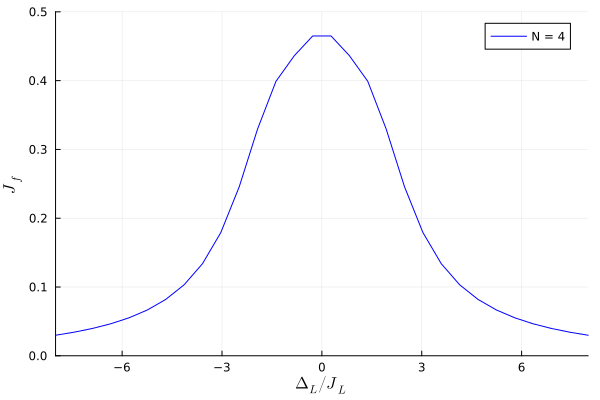

In [6]:
plot(deltaL_over_JL_values,Currents_forward, xlabel = L"\Delta_{L} / J_{L}", ylabel = L"J_{f}", color = "blue", label = "N = 4")
xlims!(-8,8)
ylims!(0,0.5)

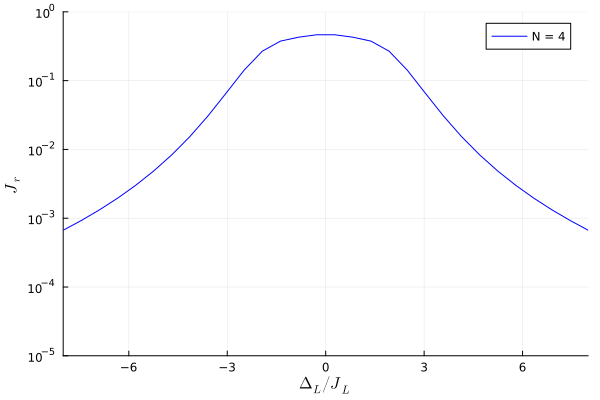

In [7]:
plot(deltaL_over_JL_values,Currents_reverse, xlabel = L"\Delta_{L} / J_{L}", ylabel = L"J_{r}", color = "blue", label = "N = 4", yaxis=:log10)
xlims!(-8,8)
ylims!(10^-5,1)


**I created the Python version because I got confused and I thought that this code of Julia was not working, but actually this code is working good.**